In [45]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from joblib import load
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import dill
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import joblib
from utils import split_data
from sklearn.model_selection import KFold, StratifiedKFold,cross_validate,cross_val_score
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
X_train,y_train = split_data.get_train_data()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25832 entries, 0 to 25831
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         25832 non-null  object 
 1   CellName     25832 non-null  object 
 2   PRBUsageUL   25832 non-null  float64
 3   PRBUsageDL   25832 non-null  float64
 4   meanThr_DL   25832 non-null  float64
 5   meanThr_UL   25832 non-null  float64
 6   maxThr_DL    25832 non-null  float64
 7   maxThr_UL    25832 non-null  float64
 8   meanUE_DL    25832 non-null  float64
 9   meanUE_UL    25832 non-null  float64
 10  maxUE_DL     25773 non-null  float64
 11  maxUE_UL     25773 non-null  float64
 12  maxUE_UL+DL  25828 non-null  object 
dtypes: float64(10), object(3)
memory usage: 2.6+ MB


In [31]:
X_test,y_test = split_data.get_test_data()

Pipeline(steps=[('SetNull', NullEncoder()),
                ('TimeConversion', TimeConversation()),
                ('ObjectToFloat', ObjectToFloat()), ('Scaling', Scaling()),
                ('OneHotEncoding',
                 OneHotEncoding(categories=array(['10ALTE', '10BLTE', '10CLTE', '1ALTE', '1BLTE', '1CLTE', '2ALTE',
       '3ALTE', '3BLTE', '3CLTE', '4ALTE', '4BLTE', '4CLTE', '5ALTE',
       '5BLTE', '5CLTE', '6ALTE', '6BLTE', '6CLTE', '6ULTE', '6VLTE',
       '6WLTE', '7ALTE', '7BLTE', '7CLTE', '7ULTE', '7VLTE', '7WLTE',
       '8ALTE', '8BLTE', '8CLTE', '9ALTE', '9BLTE'], dtype=object)))])
0.8035363457760314


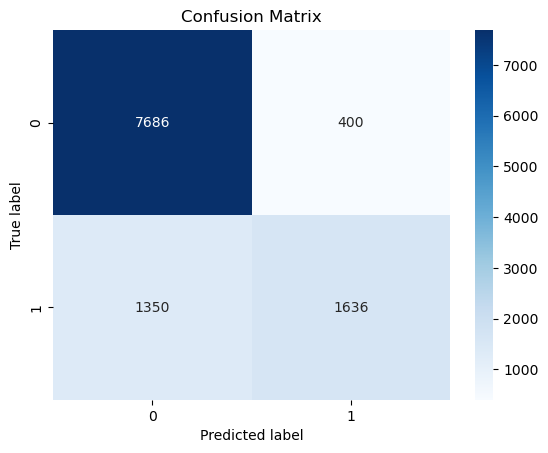

In [56]:
with open('pipelines/PreprocessingPipeline2.0.pkl', 'rb') as f:
    pipeline,categories = dill.load(f)
print(pipeline)
pipeline.transform(X_train)
# Define the model pipeline
xgboost = Pipeline([
    ('xgboost', XGBClassifier()),
])
xgboost.fit(pipeline.transform(X_train), y_train)
# model.fit(pipeline.fit_transform(X_train), y_train)
ModelPipeline  = Pipeline([
    ('preprocessing', pipeline),
    ('model',xgboost)
])
ModelPipeline.fit(X_train, y_train)
predict = ModelPipeline.predict(X_test)
print(recall_score(predict,y_test))
cm = confusion_matrix(y_test, predict)
# Visualize the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [57]:
with open('../models/ModelXGboost.pkl', 'wb') as f:
    dill.dump(xgboost, f)

In [55]:

# Define the pipeline
pipe = Pipeline([
    ('preprocessing', pipeline),
    ('model',xgboost)
])

# Define the hyperparameters to tune
params = {
    'model__learning_rate': [0.01, 0.1, 0.5],
    'model__max_depth': [3, 5, 7],
    'model__n_estimators': [50, 100, 200]
}

# Define the GridSearchCV object
grid = GridSearchCV(pipe, param_grid=params, cv=5, scoring='recall')

# Fit the GridSearchCV object to the data
grid.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid.best_params_)
print("Best recall score: ", grid.best_score_)

ValueError: Invalid parameter learning_rate for estimator Pipeline(steps=[('xgboost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))]). Check the list of available parameters with `estimator.get_params().keys()`.

In [6]:

data = pd.read_csv('../data/raw/train.csv',  encoding= 'unicode_escape')
data = data.drop(["Unusual"], axis=1)
with open('pipelines/PreprocessingPipeline2.0.pkl', 'rb') as f:
    pipeline, categories = dill.load(f)
print(pipeline)
data = pipeline.transform(data)
data

Pipeline(steps=[('SetNull', NullEncoder()),
                ('TimeConversion', TimeConversation()),
                ('ObjectToFloat', ObjectToFloat()), ('Scaling', Scaling()),
                ('OneHotEncoding',
                 OneHotEncoding(categories=array(['10ALTE', '10BLTE', '10CLTE', '1ALTE', '1BLTE', '1CLTE', '2ALTE',
       '3ALTE', '3BLTE', '3CLTE', '4ALTE', '4BLTE', '4CLTE', '5ALTE',
       '5BLTE', '5CLTE', '6ALTE', '6BLTE', '6CLTE', '6ULTE', '6VLTE',
       '6WLTE', '7ALTE', '7BLTE', '7CLTE', '7ULTE', '7VLTE', '7WLTE',
       '8ALTE', '8BLTE', '8CLTE', '9ALTE', '9BLTE'], dtype=object)))])


,Time,PRBUsageUL,PRBUsageDL,meanThr_DL,meanThr_UL,maxThr_DL,maxThr_UL,meanUE_DL,meanUE_UL,maxUE_DL,...,CellName_7BLTE,CellName_7CLTE,CellName_7ULTE,CellName_7VLTE,CellName_7WLTE,CellName_8ALTE,CellName_8BLTE,CellName_8CLTE,CellName_9ALTE,CellName_9BLTE
0,-0.466684,-0.508567,-0.600417,-0.578625,-0.312281,-0.860451,-0.336988,-0.569604,0.665886,-0.669510,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.952251,0.889801,-0.127242,-0.143745,-0.164396,4.092399,-0.247547,-0.003490,0.835839,0.457255,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.648599,-0.532664,-0.553146,-0.156412,-0.204211,0.851243,-0.189979,-0.476031,-1.222273,-0.669510,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.425229,-0.605076,1.433628,0.319282,0.097245,0.125501,-0.078626,0.941593,-1.222273,1.020637,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.025017,-0.629173,1.622711,1.937767,0.273569,1.260863,-0.109502,1.273776,-1.222273,1.020637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25827,1.170548,2.036934,0.325340,0.343208,0.137060,1.063177,-0.140776,0.749769,-1.222273,1.584020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25828,0.552038,0.407613,0.345466,0.645794,-0.062015,1.230078,-0.187987,-0.097062,0.759267,0.457255,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25829,1.316080,-0.195181,-0.600417,-0.394259,-0.158709,-0.418137,-0.250336,-0.335672,0.684562,-0.106127,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25830,1.134166,0.009767,-0.505407,-0.501219,-0.221275,0.535313,0.123561,-0.190635,0.665886,-0.106127,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
